In [1]:
import os, sys
import numpy as np
import pickle as pkl
from random import randint
import matplotlib.pyplot as plt
import scipy.interpolate as itp
from itertools import product, chain
from multiprocessing import Pool, Process

from outputloc import outputloc

from peaks import *

## AZ simulation in STEPS

In [2]:
from MFB_model import *
mdl, sim, r = get_MFB_model()

## Testing a single trail with STEPS

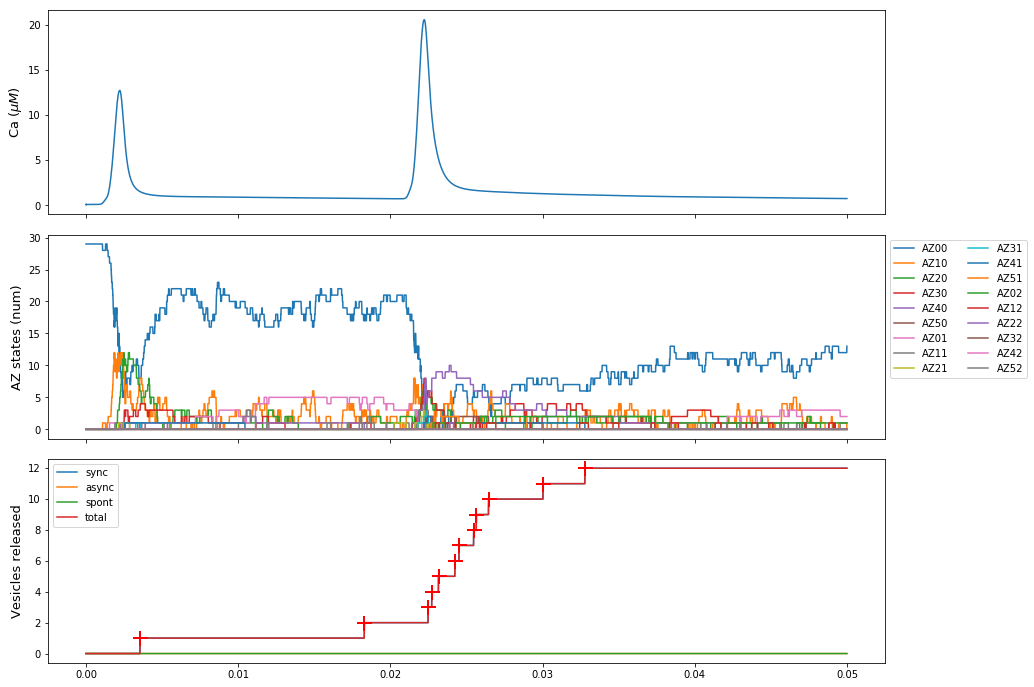

In [3]:
CaFile = "/data/kabir/STEPS/AZ/ercontrol_ryr_single"
CaData = np.genfromtxt(CaFile, unpack=True)

T = np.arange(CaData[0][0], CaData[0][-1], 1e-5)
CaInterp = itp.interp1d(CaData[0], CaData[1])
CaInterpData = CaInterp(T)

resCa, resAZ, vesRel = simAZ(T, CaInterpData, sim, r)

nFig = 3
figure, ax = plt.subplots(nFig, figsize=(15, 4*nFig), sharex=True)
figure.subplots_adjust(hspace=0.1)
labelfontsize = 13

ax[0].plot(T, resCa/cytVolVal*1.66*1e-3, label='Ca')
ax[0].set_ylabel(r'Ca ($\mu M$)', fontsize=labelfontsize)

for mol in azMolName[:18]:
    i = azMolName.index(mol)
    ax[1].plot(T, resAZ[:,i], label=mol)
ax[1].set_ylabel('AZ states (num)', fontsize=labelfontsize)
ax[1].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=2)

vesRelSync  = np.sum(vesRel[:,:3], axis=1)
vesRelAsync = np.sum(vesRel[:,3:-1], axis=1)
vesRelSpont = vesRel[:,-1]
vesRelTot   = np.sum(vesRel, axis=1)

ax[2].plot(T, vesRelSync, label='sync')
ax[2].plot(T, vesRelAsync, label='async')
ax[2].plot(T, vesRelSpont, label='spont')
ax[2].plot(T, vesRelTot, label='total')
    
ax[2].set_ylabel('Vesicles released', fontsize=labelfontsize)
ax[2].legend()

peaks = detect_peaks(vesRelTot, edge='rising', show=False)
ax[2].plot(T[peaks], vesRelTot[peaks], '+', mfc=None, mec='r', mew=2, ms=15)
#print(T[peaks])

plt.show()

In [4]:
def runAZTrials(CaFile):
    CaData = np.genfromtxt(CaFile, unpack=True) # in uM
    resCa, resAZ, vesRel = simAZ(CaData[0], CaData[1], sim, r, RRP=7)
    vesRelTot = np.sum(vesRel, axis=1)
    pks = detect_peaks(vesRelTot, edge='rising', show=False)
    return list(CaData[0,pks])


def getVesRel(CaFilePath, trials=2000):    
    p = Pool()
    vesRelTimes = []

    vesRelTime = p.map(runAZTrials, [CaFilePath]*trials)
    #vesRelTime = np.sort(list(chain(*result)))
    vesRelTimes.append(vesRelTime)

    return vesRelTimes

In [5]:
case=['control','2x','3x']
ryr_case=['double','single']

cases=list(product(case,ryr_case)) #
cases.remove(('control','double'))


fileLoc = "/data/kabir/STEPS/AZ/"
fileList = ['er'+c+'_ryr_'+r for (c,r) in cases]
print(fileList)

['ercontrol_ryr_single', 'er2x_ryr_double', 'er2x_ryr_single', 'er3x_ryr_double', 'er3x_ryr_single']


In [16]:
vdcc_num=['40','60']#[0] '20',
case=['control','2x','3x']#[2]
ryr_case=['single','double']

cases=list(product(vdcc_num,case,ryr_case))

cases=[c for c in cases if c[1]!='control' or c[2]!='double']


fileList=[]
for case in cases:
    fileList.append(''.join(case))
fileLoc="/data/kabir/STEPS/ODE/AZ/"

In [10]:
vesdata={}

for CaFile in tqdmn(fileList):
    CaFilePath = os.path.join(fileLoc, CaFile)
    vesdata[CaFile] = getVesRel(CaFilePath, trials=100)
    
    #with open(os.path.join(resultPath, dir, 'vesData.dat'),"wb") as outfile:
    #    pk.dump(vesData, outfile)

In [11]:
vesdata

{'20controlsingle': [[[],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [0.02401],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [0.03081],
   [],
   [],
   [0.02401],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [0.0297],
   [],
   [],
   [0.02788],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [0.03013],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [0.01824],
   [],
   [],
   [],
   [],
   [0.02447],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [0.0459]]],
 '202xsingle': [[[0.02434],
   [],
   [],
   [],
   [],
   [],
   [],
   [0.04981],
   [],
   [],
   [],
   [0.02598],
   [],
   [],
   [],
   [],
   [0.02951],
   [],
   [],
   [],
   [],
   [0.03056],
   [],
   [],
 

## Save vesdata

In [12]:
#dump_loc=outputloc+"vesreldata/"
dump_loc="/data/kabir/STEPS/ODE/vesreldata/"
if not os.path.exists(dump_loc):
    os.makedirs(dump_loc)
dump_loc=dump_loc+"data"
print(dump_loc)
with open(dump_loc,'wb') as file:
    pkl.dump(vesdata,file)

/data/kabir/STEPS/ODE/vesreldata/data


## Load Vesdata

In [12]:
dump_loc="/data/kabir/STEPS/ODE/vesreldata/data"
with open(dump_loc,'rb') as file:
    vesdata=pkl.load(file)

In [13]:
ti, tf, dt = 0, 50.0e-3, 1e-5
T = np.arange(ti, tf+dt, dt)

In [17]:
for CaFile in tqdmn(fileList):
    CaFilePath = os.path.join(fileLoc, CaFile)
    CaData = np.genfromtxt(CaFilePath, unpack=True)
    Peaks=detect_peaks(CaData[1,:],mph=4.25)
    vesData=vesdata[CaFile]
    count1=0
    count2=0
    for trial in vesData[0]:
        P1rel=False
        P2rel=False
        for release in trial:
            if release>T[Peaks[0]]-1e-3 and release<T[Peaks[0]]+20e-3:
                P1rel=True
            if release>T[Peaks[1]]-1e-3 and release<T[Peaks[1]]+20e-3:
                P2rel=True
        count1+=P1rel
        count2+=P2rel
    print("VDCC"+CaFile[:10],"\t",count1/len(vesData[0]),"\t",count2/len(vesData[0]),"\t",count2/count1)

VDCC40controls 	 0.04 	 0.15 	 3.75
VDCC402xsingle 	 0.17 	 0.77 	 4.529411764705882
VDCC402xdouble 	 0.5 	 0.62 	 1.24
VDCC403xsingle 	 0.95 	 0.93 	 0.9789473684210527
VDCC403xdouble 	 0.97 	 0.9 	 0.9278350515463918
VDCC60controls 	 0.15 	 0.62 	 4.133333333333334
VDCC602xsingle 	 0.56 	 0.95 	 1.6964285714285714
VDCC602xdouble 	 0.83 	 0.91 	 1.0963855421686748
VDCC603xsingle 	 1.0 	 0.97 	 0.97
VDCC603xdouble 	 1.0 	 0.92 	 0.92



In [29]:
T[Peaks[1]]

0.022250000000000002

In [83]:
for CaFile in tqdmn(fileList):
    vesData=vesdata[CaFile]
    count1=0
    count2=0
    for trial in vesData[0]:
        P1rel=False
        P2rel=False
        for release in trial:
            if release>T[Peaks[0]]-1e-3 and release<T[Peaks[0]]+20e-3:
                P1rel=True
            if release>T[Peaks[1]]-1e-3 and release<T[Peaks[1]]+20e-3:
                P2rel=True
        count1+=P1rel
        count2+=P2rel
    print(CaFile,"\t",count1/len(vesData[0]),"\t",count2/len(vesData[0]),"\t",count2/count1)

ercontrol_ryr_single 	 0.4 	 0.97 	 2.425
er2x_ryr_double 	 0.97 	 0.99 	 1.0206185567010309
er2x_ryr_single 	 0.89 	 0.99 	 1.1123595505617978
er3x_ryr_double 	 1.0 	 0.88 	 0.88
er3x_ryr_single 	 1.0 	 0.97 	 0.97


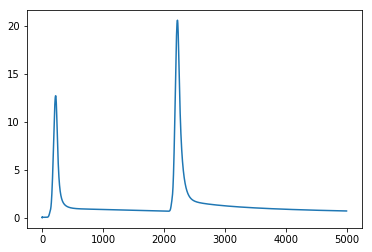

In [51]:
plt.plot(CaData[1,:])

In [ ]:
vesData = getVesRel(dir, RRPs=range(7,38,20), trials=2000)
print(vesData)

In [ ]:
p=Pool(23)
info = list(product(dirs[735:758], [range(7,8)], [100]))

%time vesData = p.starmap(getVesRel, info)

#with open(os.path.join(resultPath, dir, 'vesData.dat'),"wb") as outfile:
#    pk.dump(vesData, outfile)

In [ ]:
dir = 'nVDCC_3_dVDCC_60_nAZ_20'
nAZ = int(dir.split('_')[-1])
CaFile = os.path.join(resultPath, dir, 'CaConc.dat')
CaData = np.genfromtxt(CaFile, usecols=range(nAZ+1), unpack=True) # in uM

with open(os.path.join(resultPath, dir, 'vesData.dat'),"rb") as infile:
    vesData = pk.load(infile)

vesRelTimes = vesData['7']

nFig = 3
figure, ax = plt.subplots(nFig, figsize=(15, 4*nFig), sharex=True)
figure.subplots_adjust(hspace=0.1)
for n in range(nAZ):
    ax[0].plot(CaData[0], CaData[n+1], label=str(n+1))
    ax[1].plot(np.sort(vesRelTimes[n]), range(1,len(vesRelTimes[n])+1))
    ax[2].hist(np.sort(vesRelTimes[n]), bins=np.arange(0,CaData[0][-1],0.0003), histtype='step', alpha=0.4, lw=2)

In [ ]:
vesData